## Make a depth to surface area relationship for a reservoir
This notebook will create a table of the depth to surface area relationship for a reservoir. You can then know what the surface area is based on the depth gauge reading. Read the instructions carefully and you should be able to create your own table for any of the reservoirs in the 00_Library or 90_Library folders.

Inputs: 
* csv file of storage level data downloaded from http://www.bom.gov.au/waterdata/
* A shapefile of all the reservoirs with their gauge IDs attached (I made one in ArcGIS from the National Hydropolys dataset)

Outputs:
* Images of the reservoir at each 1m depth slice
* A csv file of the depth the surface area table

Select a code block and press 'Shift' + 'Enter' to run. They have to be run in order. Let's start with the imports:

In [1]:
# Import the modules we will need. This includes modules by DEA to help manage the OpenDataCube.
import os
import xarray as xr
import numpy as np
import pandas as pd
import csv
from tqdm.auto import tqdm #this one is a loading bar, it's cool to add loading bars to loops
import rasterio.crs
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datacube

import sys
sys.path.append('../../Scripts')
from dea_spatialtools import xr_rasterize
from dea_datahandling import wofs_fuser #this joins wofs data across tiles correctly
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## User inputs
Put the location of your csv file and the reservoirs shapefile in here. All of the file names are in caps and you can press tab to fill the rest of the file name. Check out the Library folder to see the gauge data I have. 

In [2]:
#User inputs
csv = 'Library/GORDON_646.1.csv'
reservoirs_shape_file = 'Named_Reservoirs/Named_Reservoirs9.shp' #This shapefile has the gauge ID attached to the polygons
todays_date = '11-05-2021' #for most up to date WOFS data

## Find corresponding reservoir polygon
If you get an error about 'str' object has no attribute 'astype', you need to hash out the line indicated, or if it's hashed out and you get an error, unhash it. 

In [3]:
#Get the name and ID of the gauge 
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID_str = gauge_number_df.at[0, 'gauge_ID']
ID_str = ID_str.astype(str) #hash/unhash this line out if you get an error
# Read the reservoirs shapefile
gdf = gpd.read_file(reservoirs_shape_file)
gdf = gdf.set_index(['gauge_ID'])

row = gdf.loc[ID_str]
polygon = row.geometry
print('The gauge ID is ', ID_str)
print('Here is a picture of the reservoir polygon:')
polygon

The gauge ID is  646.1
Here is a picture of the reservoir polygon:


## Query satellite data
Now we'll query all of the WOFS data ever for inside that polygon. We'll mask out anything outside the polygon because we don't want other waterbodies getting counted in the image.

This block has the dc.load() function in it (dc stands for datacube). Usually this loads the satellite images from the Open DataCube, but I put a dask_chunks argument in there so it won't load the images yet, it will just load the parameters, because that's way faster and that's enough to link the data. This cell can take a minute to run, longer for large dams. You'll know when it's finished when the square brackets in the top left stop being a star and become a number.

In [4]:
query = {'time': ('01-01-1988', todays_date)}

dc = datacube.Datacube(app='dc-WOfS') #this is how you access the open data cube where the satellite data is

geom = geometry.Geometry(geom=row.geometry, crs=gdf.crs)
query.update({'geopolygon': geom})

#Load parameters of satellite data in preparation to merge it with gauge data
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, 
                     group_by='solar_day', fuse_func = wofs_fuser, **query) #wofs_fuser is important, it fixes thing on the edge of tiles

In [5]:
# Mask out anything outside the reservoir extent
poly_mask = xr_rasterize(gdf.loc[[ID_str]], wofs_albers)
wofs_albers = wofs_albers.where(poly_mask, other=wofs_albers.water.nodata) #put other argument or all the data turns into 0?

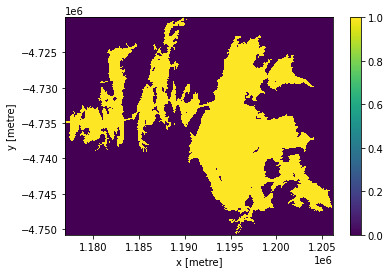

In [6]:
poly_mask.plot()

## Merge depth gauge data with satellite data
We can link the gauge data and satellite data together on the time axis. Then we can call the satellite passes by depth, instead of just by date. 

In [7]:
#Read the gauge data
data = pd.read_csv(csv, error_bad_lines = False, skiprows=9, escapechar='#',
                     parse_dates=['Timestamp'], 
                     index_col=('Timestamp'),
                    date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = data.drop(columns=['Quality Code', 'Interpolation Type'])

#Merge the gauge data with the satellite data
gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge
gauge_data = gauge_data.dropna()

## Organise the depth gauge data into slices of depth
This cell also has a part in it where it takes every 2m instead of every 1m if the reservoir is really deep (goes up and down more than 25m). This makes it more accurate in my opinion because you get more passes per depth interval, so the images that get generated are more accurate. You can just interpolate every other meter later. 

In [8]:
#Get the depth range and intervals
gauge_data['Value'] = gauge_data['Value'].round(0)
depth_integers = gauge_data.astype(np.int64)

In [9]:
#depth_integers.to_csv('DUNHAM_integers.csv')

In [10]:
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

#Take every 2m of depth if the reservoir is large 
if len(integer_list) > 25:
    integer_list2 = integer_list[::2]
    print('This reservoir will take every 2m instead of every 1m, because it is quite large.')
else:
        integer_list2 = integer_list
        print('This reservoir will take every 1m of depth')
        
print('Number of depth intervals = ', len(integer_list2))
integer_list.sort()
integer_list2

This reservoir will take every 2m instead of every 1m, because it is quite large.
Number of depth intervals =  23


[270,
 272,
 274,
 276,
 278,
 280,
 282,
 284,
 286,
 288,
 290,
 292,
 294,
 296,
 298,
 300,
 302,
 304,
 306,
 269,
 267,
 265,
 263]

## Generate an image of the reservoir at each meter of depth
Here's the part where the satellite data gets called out of the datacube and organised into depth slices. In you files on the left hand side there you should see a folder called images. That's where all the pictures will get saved as png files. Download those images to your local machine and then I suggest delete them off the sandbox because they just take up space and you don't need them for anything else. This cell will take a bit longer to run because it has to load a lot of satellite passes and cload mask them all.   

  0%|          | 0/23 [00:00<?, ?it/s]

/env/lib/python3.6/site-packages/xarray/plot/utils.py:427: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=figsize)
/env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/env/lib/python3.6/site-packages/xarray/plot/utils.py:427: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fig

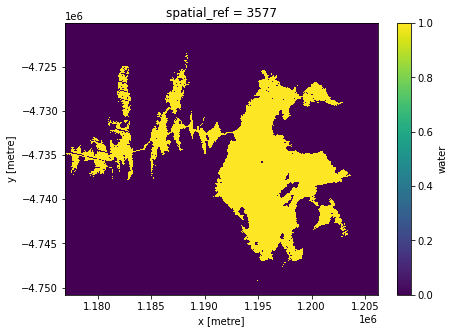

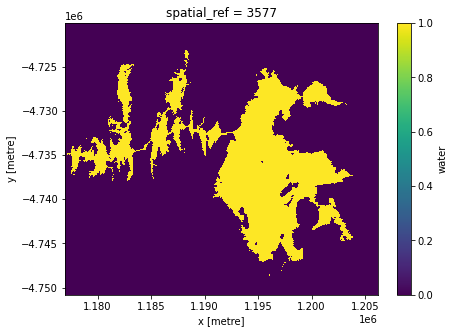

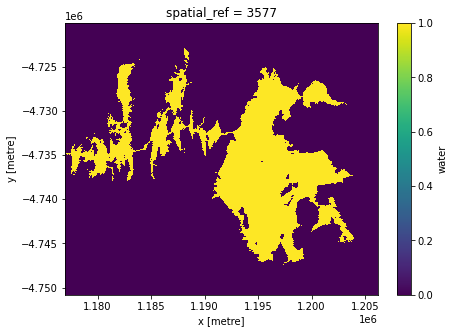

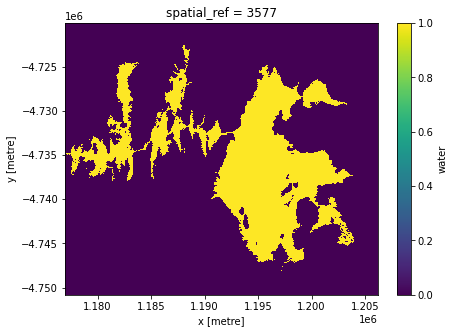

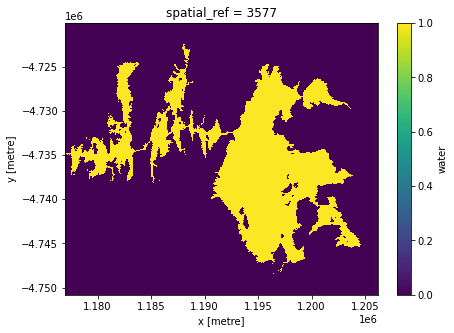

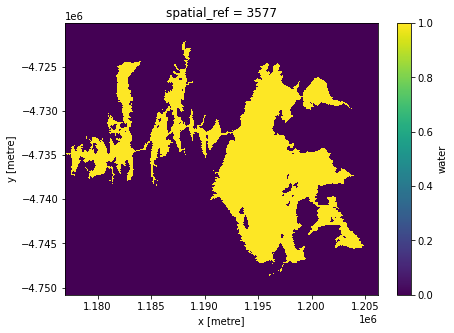

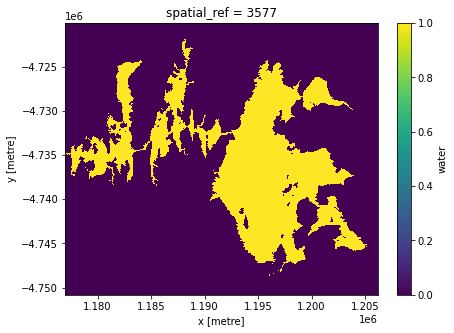

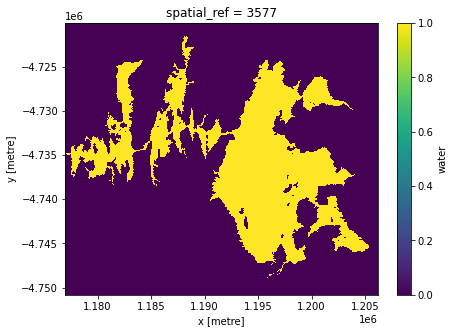

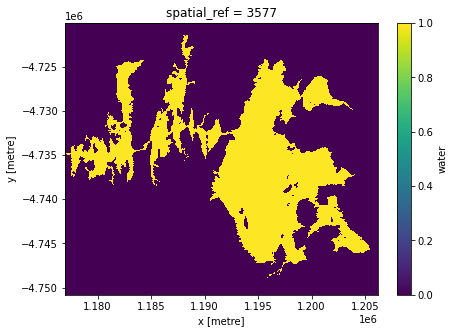

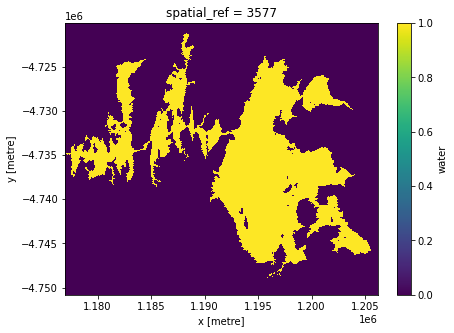

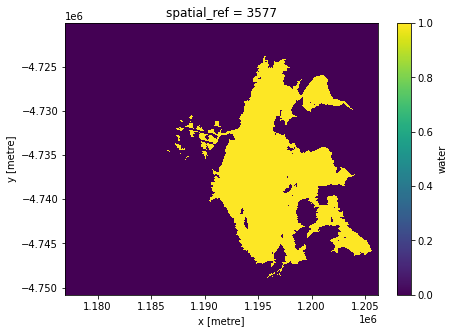

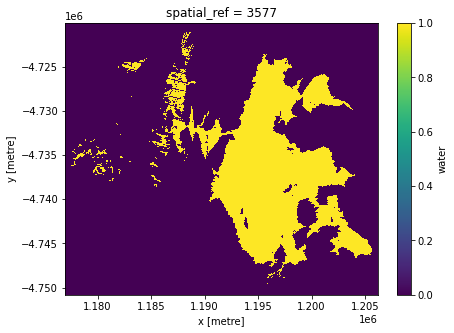

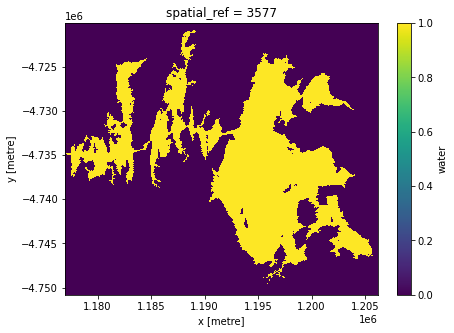

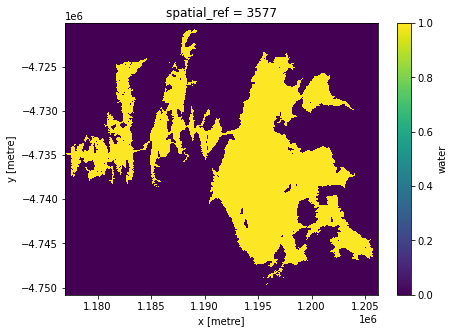

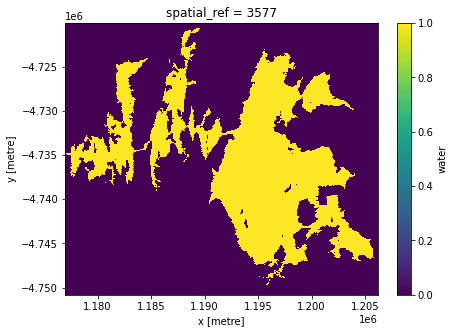

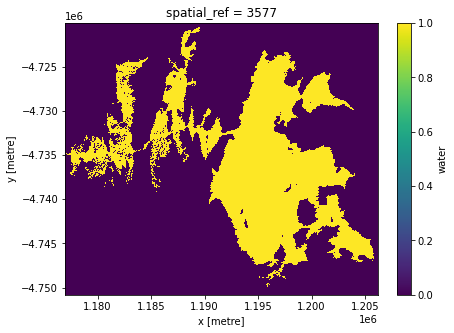

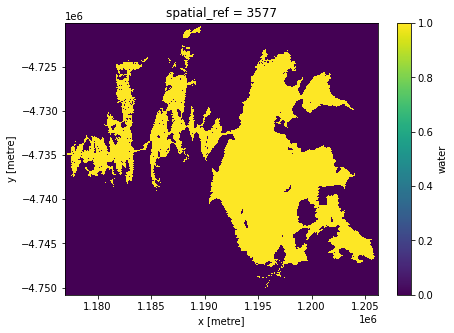

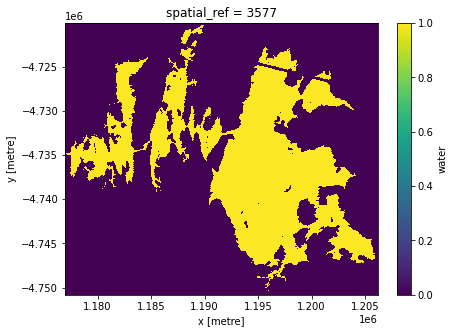

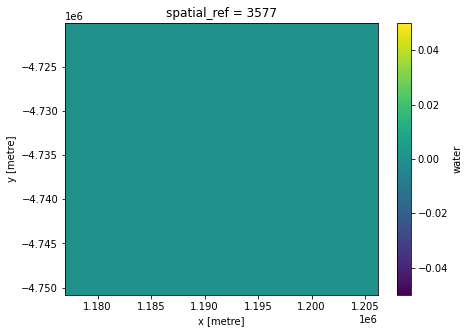

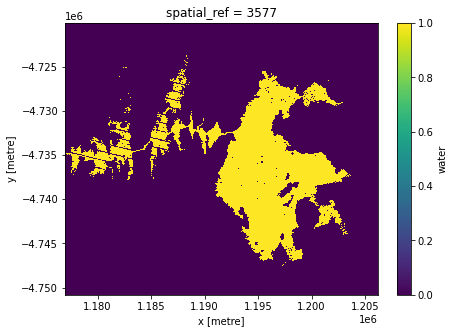

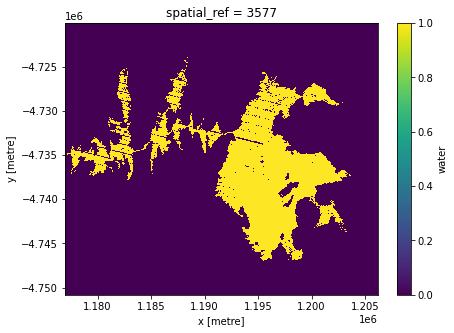

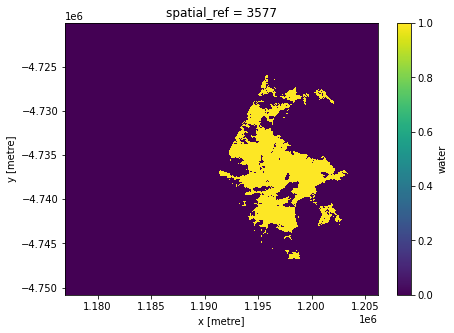

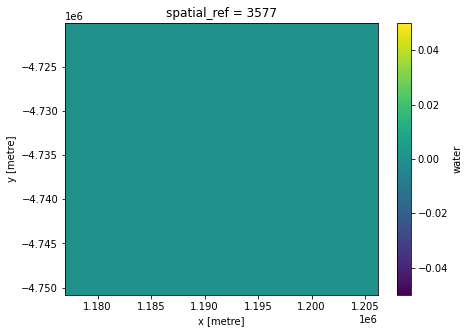

In [11]:
surface_area_list = []
number_of_images_list = []
images_post_masking = []
for i in tqdm(integer_list2, total=len(integer_list2)):
    #If there are more than 25 meters in depth intervals, take every 2m depth
    if len(integer_list) > 25:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+2), drop=True)
    else:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    
    date_list = specified_level.time.values[:250]
    number_of_images = len(date_list)
    number_of_images_list.append(number_of_images)
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.1)
    images_post_masking.append(len(clear_specified_passes.time))
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
    
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
    
        #Plotting the image (keep these hashed out if you don't want to see images)
    fig = plt.figure()
    frequency.plot(figsize = (7,5))
    name = ID_str, i
    images = plt.savefig('images/'+str(name)+'.png')
    plt.close(fig)


## Make a table of the depth to surface area relationship
Nice, you made image slices of the reservoir! Now let's make the table. You might notice that some of the images are blank or bad quality and therefore produce an inaccurate calculation of the surface area. The reason this happens is because there weren't many cloud free passes for that depth over the last 30 years. It's OK, we can fix it later. If there are outliers in the gauge data csv file, you will get a lot of zero values on the lowest or highest depths because they aren't real. These get deleted later. Anyway, let's see what the initial depth to surface area table looks like and then next we'll fix it up.

In [12]:
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list2, columns=['Depth'])
depth_to_area_df['Surface Area'] = surface_area_list
depth_to_area_df['pre masking'] = number_of_images_list
depth_to_area_df['post masking'] = images_post_masking
depth_to_area_df['ID'] = ID_str
depth_to_area_df = depth_to_area_df.sort_values(by=['Depth'])
depth_to_area_df = depth_to_area_df.reset_index()
depth_to_area_df = depth_to_area_df[['ID', 'Depth','Surface Area', 'pre masking', 'post masking']]
depth_to_area_df

,ID,Depth,Surface Area,pre masking,post masking
0,646.1,263,0,5,0
1,646.1,265,71030625,10,5
2,646.1,267,146836250,30,8
3,646.1,269,150025000,42,9
4,646.1,270,160280000,49,16
5,646.1,272,172418750,124,39
6,646.1,274,177932500,87,20
7,646.1,276,181902500,87,24
8,646.1,278,191628750,108,25
9,646.1,280,198219375,189,64


## Fix with interpolation
If you got some outliers in the depth gauge data or any dodgy images/surface area calculations, we can fix them here. This block basically says 'if the surface area calculation is zero, or smaller than the one before it, delete' because it doesn't make sense for surface area to go down if depth goes up. It will then interpolate the surface area values instead. If you did a large reservoir like Eucumbene or something, this is where every other meter gets its surface area calculated. The only thing this code won't fix is if your first non-zero value (ie lowest depth you have an image for) is a bad quality image (for example the surface area might be calculated as 20'000m2 from an image with scan lines through it, when it should have been 150'000m2) but if your first non-zero image looks ok to you then you're good. This code also won't interpolate the very highest depth if it's a bad image, it will just delete it. 

In [13]:
obs_list = []
for i, obs in depth_to_area_df.iterrows():
    if i == 0: #We always put the first point in, even if it's bad (will fix later)
        obs_list.append(obs)
        continue
    if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
        obs_list.append(obs)

obs_df = pd.DataFrame(obs_list)
obs_df2 = obs_df
obs_df2.drop(obs_df2[obs_df2['Surface Area'] == 0].index, inplace=True) #drop zero values because they stuff up the interpolation
obs_df3 = obs_df2.set_index("Depth")
min_ = obs_df3.index.min()
max_ = obs_df3.index.max()
obs_df4 = obs_df3.reindex(range(min_, max_+1))
obs_df4['Surface Area'] = obs_df4['Surface Area'].interpolate()
obs_df4['Depth'] = obs_df4.index
obs_df4['ID'] = obs_df3.at[min_, 'ID']
obs_df4 = obs_df4[['ID', 'Depth', 'Surface Area', 'post masking']]
obs_df4 = obs_df4.set_index("ID")
obs_df4 = obs_df4.sort_values(by='Depth')
obs_df4

,Depth,Surface Area,post masking
ID,,,
646.1,265,7.103062e+07,5.0
646.1,266,1.089334e+08,NaN
646.1,267,1.468362e+08,8.0
646.1,268,1.484306e+08,NaN
646.1,269,1.500250e+08,9.0
646.1,270,1.602800e+08,16.0
646.1,271,1.663494e+08,NaN
646.1,272,1.724188e+08,39.0
646.1,273,1.751756e+08,NaN


## Save the table as a csv file
OK that should look better now. You can save this table as a csv and download it to your local machine. Don't forget you can save the images too, they are in the images folder!

In [14]:
obs_df4.to_csv('images/'+ID_str +'.csv')